# 1. Obtenemos los Datos

In [2]:
# Obtener el cojunto de datos MNIST
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',as_frame=False)

In [3]:
X,y = mnist.data, mnist.target

In [4]:
# Hay 70.000 imagenes, cada imagen tiene 784 caracteristicas (28 x 28 pixeles)
# valor desde 0  (blanco) hatas 255 (negro)
X.shape 

(70000, 784)

In [5]:
y.shape # el digito

(70000,)

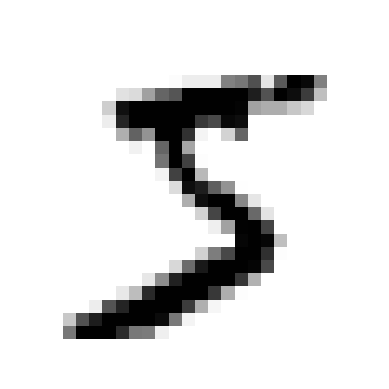

In [6]:
import matplotlib.pyplot as plt
# observemos el digito de la primera fila
digito = X[0].reshape(28,28)
plt.imshow(digito,cmap='binary')
plt.axis("off")
plt.show()

In [7]:
y[0] # efectivamene es un 5

'5'

# 2. Set Train y Set Test

In [9]:
# el cojunto de datos ya esta dividido 
X_train,X_test,y_train,y_test = X[:60_000],X[60_000:],y[:60_000],y[60_000:]

# 3. Clasificadores

## 3.1 Clasficacion binaria: "5" y "No 5"

In [12]:
y_train_5 = (y_train=='5')
y_test_5 = (y_test=='5')

In [13]:
(y_train=='5').sum()

5421

### 3.1.1 Entrenamiento

In [15]:
# Se utiliza Stochastic Grandient Descent
# estrictamente, SGD es una técnica de optimización y no un modelo de machine learning
# En contexto para el que se usa, clasificará las instancias a la clase más frecuente.
from sklearn.linear_model import SGDClassifier

sgd_clf= SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [16]:
digito = digito.reshape(1,-1)
sgd_clf.predict(digito)

array([ True])

### 3.1.2 Medidas de rendimiento

#### Exactitud

In [19]:
# Los porcentaje tan elevados se deben a que existen muy poco "no 5"
# "la exactitud" no es una buena medida si las clases tienen una frecuencia muy distinta.
from sklearn.model_selection import cross_val_score
val_cross = cross_val_score(sgd_clf,X_train, y_train_5,cv=3,scoring='accuracy')
print(val_cross)

[0.95035 0.96035 0.9604 ]


In [20]:
y_train_5.sum() / y_train_5.shape[0]

0.09035

#### Confusion Matrix

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
# cross_val_predict es útil para obtener una prediccion limpia (fuera de la muestra)
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [23]:
mat_confu = confusion_matrix(y_train_5,y_train_pred)


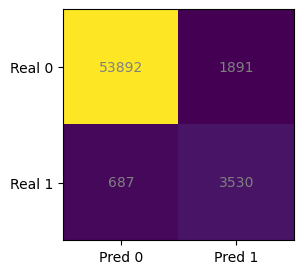

In [24]:
import numpy as np

ig,ax = plt.subplots(figsize=(3,3))
ax.imshow(mat_confu)
ax.set_xticks(np.arange(2),["Pred 0","Pred 1"])
ax.set_yticks(np.arange(2),["Real 0","Real 1"])
for i in range(2):
    for j in range(2):
        ax.text(j,i,mat_confu[j,i],ha="center",va="center",color="grey")
ax.grid(False)
plt.show()

#### Precision and Recall

In [26]:
# precision: Verdadero Positivos / Clasificación positiva , exactitud de una clase
# recall o sensibilidad: mide la capacidad del algoritmo para detectar una clase

# la tasa de precision es 84% y sesibilidad de 65%
from sklearn.metrics import classification_report
reporte = classification_report(y_true= y_train_5,y_pred= y_train_pred)
print(reporte)

              precision    recall  f1-score   support

       False       0.97      0.99      0.98     54579
        True       0.84      0.65      0.73      5421

    accuracy                           0.96     60000
   macro avg       0.90      0.82      0.85     60000
weighted avg       0.95      0.96      0.95     60000



#### Compensación Precision / Sensibilidad

In [28]:
# Tienes sentido usar la vurva Precision / Sensibilidad cuando la clase positiva es escasa o cuando es más interante
# los falsos positivo  que los falsos negativos.

In [29]:
from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")# para obtener las puntuaciones, en vez de la predicción

In [30]:
precisions,recalls,thresholds=precision_recall_curve(y_train_5,y_scores)

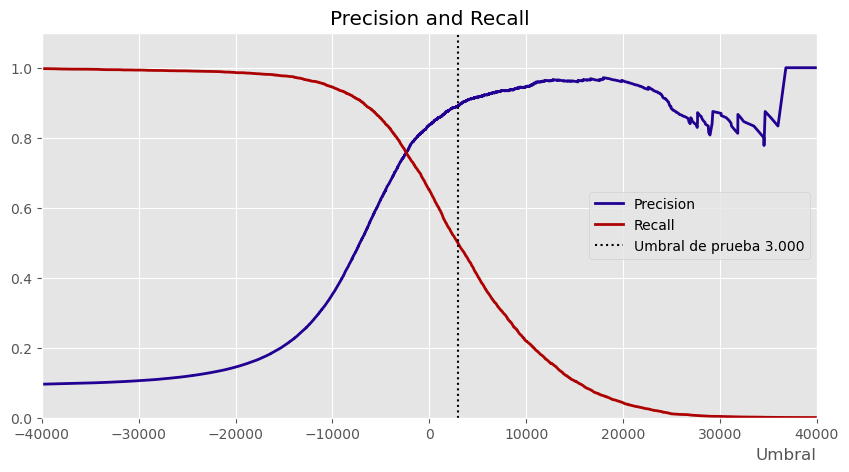

In [31]:
# config
plt.style.use("ggplot")
plt.figure(figsize=(10,5))
plt.title("Precision and Recall")
plt.xlabel("Umbral",loc="right")
# Graficos
plt.plot(thresholds,precisions[:-1],label="Precision",linewidth=2,color="#210092")
plt.plot(thresholds,recalls[:-1],label="Recall",linewidth=2,color="#ad0202")
plt.vlines(3_000,0,1.1,"k","dotted",label="Umbral de prueba 3.000") # escogido un umbral aleatorio

# config
plt.legend()
plt.xlim(-40_000,40_000)
plt.ylim(0,1.1)
plt.show()

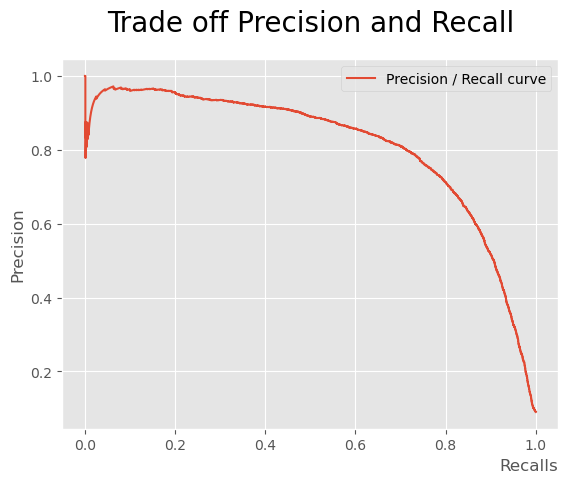

In [32]:
# Existe una trade off entre la precision y el recall, a mayor umbral, la precision es mayor y el recall es menor
# Modificando el valor del umbral se puede tener la precision que se desee a costa de reducir el recall.
fig,ax = plt.subplots()
ax.plot(recalls,precisions,label="Precision / Recall curve")
ax.set_title("Trade off Precision and Recall",fontsize=20, pad=20)
ax.set_xlabel("Recalls",loc="right")
ax.set_ylabel("Precision",loc="center")
ax.legend()
plt.show()

In [33]:
# Obtener una precision de al menos el 90%
idx = (precisions>=0.90).argmax()
thresholds_for_90 = thresholds[idx]
print(thresholds_for_90)

3370.0194991439557


In [34]:
# se comprueba la precision y recall dado el umbral elegido de 3.370,01
from sklearn.metrics import precision_score, recall_score
y_train_pred_90 = (y_scores>thresholds_for_90)
precision_for_90 = precision_score(y_train_5,y_train_pred_90)
recall = recall_score(y_train_5,y_train_pred_90)
print(f"Precision buscada: {precision_for_90} \nRecall: {recall}", "Al subir la precision hasta 90%, la sensibilidad se reduce hasta el 48%")

Precision buscada: 0.9 
Recall: 0.47980077476480354 Al subir la precision hasta 90%, la sensibilidad se reduce hasta el 48%


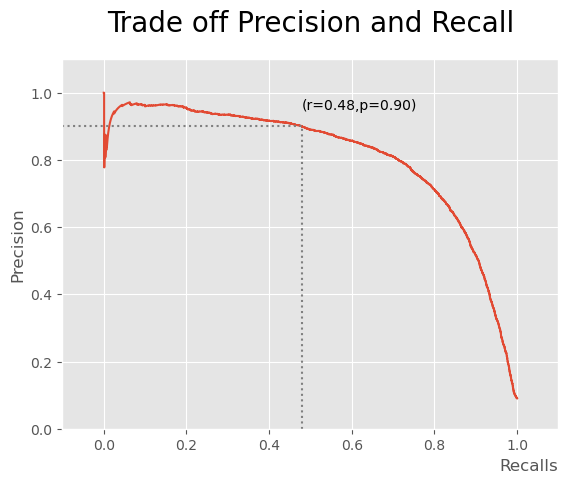

In [35]:
fig,ax = plt.subplots()
ax.plot(recalls,precisions,label="Precision / Recall curve")
ax.vlines(round(recall,2),0.0,0.9,color="gray",linestyles='dotted')
ax.hlines(0.9,-0.1,round(recall,2),color="gray",linestyles='dotted')
ax.text(round(recall,2),0.95,"(r=0.48,p=0.90)")
ax.set_title("Trade off Precision and Recall",fontsize=20, pad=20)
ax.set_xlabel("Recalls",loc="right")
ax.set_ylabel("Precision",loc="center")
ax.set_xlim(-0.1,1.1)
ax.set_ylim(0,1.1)
plt.show()

#### Curva ROC

In [37]:
# La curva ROC traza el Recall (o Tasa de Verdaderos Positivos) vs  a la Tasa de Falsos Positivo (FPR o (1-TNR))
#TNR o tasa de verdaderos negativos,tambien es llamado como especificidad
from sklearn.metrics import roc_curve
fpr,tpr,threshold = roc_curve(y_train_5,y_scores)
# Para tener una precision al menos de 90
idx = (threshold<=thresholds_for_90).argmax()
tpr_90,fpr_90,= tpr[idx],fpr[idx]

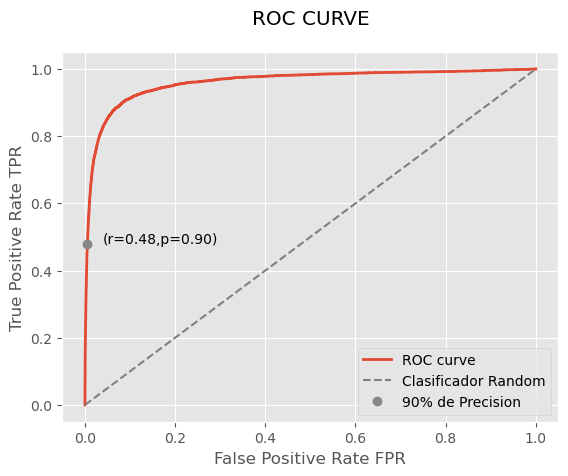

In [38]:
fig,ax = plt.subplots()
ax.plot(fpr,tpr,linewidth=2,label="ROC curve")
ax.plot([0,1],[0,1],"--",label="Clasificador Random",color="grey")
ax.plot([fpr_90],[tpr_90],"o",label="90% de Precision",color="#888686") # un buen clasificador obtendrá un se situa arriba de este
ax.text(0.04,0.48,"(r=0.48,p=0.90)")

ax.legend()
ax.set_xlabel("False Positive Rate FPR",loc="center")
ax.set_ylabel("True Positive Rate TPR",loc="center")
ax.set_title("ROC CURVE",pad=20)
plt.show()

#### RandomForestClassifier

In [40]:
# este clasificador no cuenta con un método decision_function, pero tienee predict_proba, lo que servirá como puntuación
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

In [41]:
print(y_probas_forest[:5])# la segunda columna son las probabilidades estimadas de la clase positiva

[[0.11 0.89]
 [0.99 0.01]
 [0.96 0.04]
 [1.   0.  ]
 [0.99 0.01]]


In [42]:
y_scores_forest = y_probas_forest[:,1]
precisions_forest,recalls_forest,thresholds_forest = precision_recall_curve(y_train_5,y_scores_forest)

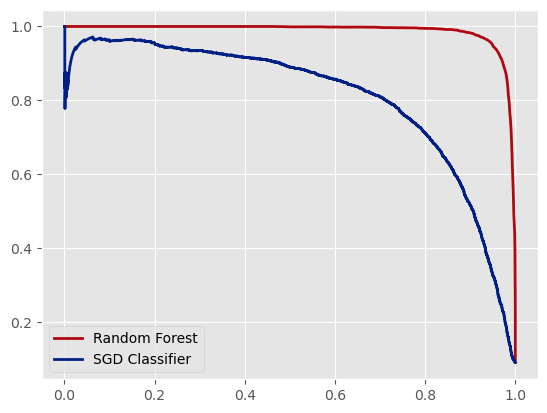

In [43]:
# Tiene mejor aspecto, dado que el trade off llega más tarde en RandomForest
fig,ax =plt.subplots()
ax.plot(recalls_forest,precisions_forest,label="Random Forest",linewidth=2,color="#af0810")
ax.plot(recalls,precisions,label="SGD Classifier",linewidth=2,color="#002085")
ax.legend()
plt.show()

In [44]:
y_train_pred_forest =(y_probas_forest>= 0.5)
reporte_forest = classification_report(y_true= y_train_5, y_pred= y_train_pred_forest[:,1])

In [45]:
print(reporte,reporte_forest,sep="\n\n")
# la precision se mejora de 84% a 99% y el recall se mejora de 65% a 87%

              precision    recall  f1-score   support

       False       0.97      0.99      0.98     54579
        True       0.84      0.65      0.73      5421

    accuracy                           0.96     60000
   macro avg       0.90      0.82      0.85     60000
weighted avg       0.95      0.96      0.95     60000


              precision    recall  f1-score   support

       False       0.99      1.00      0.99     54579
        True       0.99      0.87      0.93      5421

    accuracy                           0.99     60000
   macro avg       0.99      0.94      0.96     60000
weighted avg       0.99      0.99      0.99     60000



## 3.2 Clasificación Multiclase

In [47]:
# Existen clasificadores multiclase nativos como LogisticRegreession, RandomForestClassifier y GaussianNB
# Tambien existen clasificadores estrictamente binarios: SGDClassifier y SVC, pero hay estrategias que permiten 
# utilizar estos clasificadores en clasificación multiclase.
# OvR (One Versus the Rest, One Versus All). Un clasificador detecta una clase. Si hay N clases --> N Clasificadores a entrenar
# OvO (one Versus One). Un clasificador para cada par de digitos. Si hay N clases --> N x (N-1)/2 Clasificadores a entrenar
# OvO entrena con la parte del set de datos que contiene las clases que debe distinguir.
# para la mayor se prifiere OvR, salvo SVM que prefiere OvO dado que este calsificddor es lento con sets de datos grandes.

#### SVC con OvO

In [49]:
# SVC con estrategia OvO de manera automática
from sklearn.svm import SVC
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000],y_train[:2000])

SVC(random_state=42)

In [50]:
print("Clasificadores entrenados",10*9//2)

Clasificadores entrenados 45


In [51]:
#prediicion del primer digito: 5
svm_clf.predict(digito)

array(['5'], dtype=object)

In [52]:
# la prediccion es la clase que ha ganado más duelos
digito_scores = svm_clf.decision_function(digito)
print(digito_scores) 

[[ 3.79297828  0.72949369  6.06184129  8.29800527 -0.29383983  9.30157597
   1.74723215  2.77365456  7.20601456  4.82245092]]


In [53]:
clase_id = digito_scores.argmax()
clase_pred = svm_clf.classes_[clase_id]
print(clase_pred)# es 9.3 que corresponde al '5'

5


#### SVC con OvR

In [55]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000],y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [56]:
ovr_clf.predict(digito) # se obtiene la misma prediccion

array(['5'], dtype='<U1')

In [57]:
len(ovr_clf.estimators_) # cantidad de estimadores efectivamente es N=10

10

## Análisis de errores

In [59]:
# estimaor a utilizar es SGD Classifier 
from sklearn.model_selection import cross_val_predict
sgd_clf = SGDClassifier(random_state=42)
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train,cv=3)

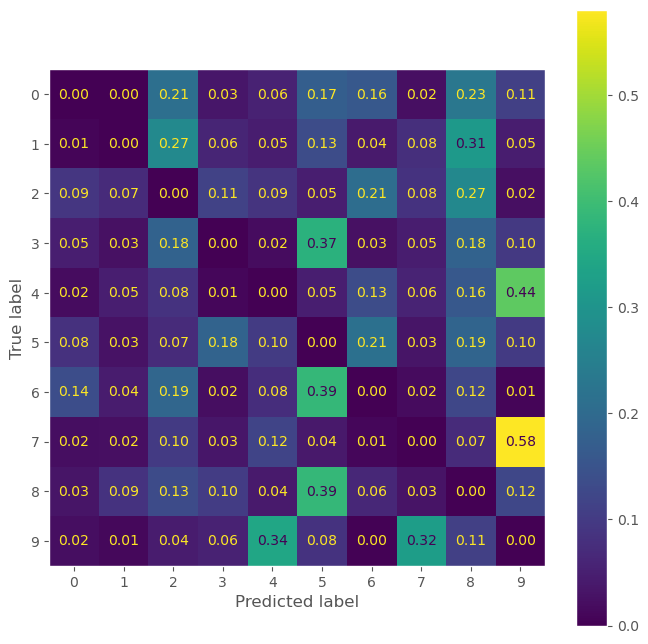

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay
fig,ax = plt.subplots(figsize=(8,8))
smaple_weight=(y_train != y_train_pred)
ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred,normalize="true",ax=ax,values_format=".2f",sample_weight=smaple_weight)
plt.grid(False)
plt.show()